In [1]:
pip install opencv-python==3.4.2.16

     |████████████████████████████████| 25.0MB 181kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


In [2]:
pip install opencv-contrib-python==3.4.2.16

     |████████████████████████████████| 30.6MB 160kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [4]:
import argparse as ap
import cv2
import numpy as np
import os
import joblib
from scipy.cluster.vq import *

from sklearn import preprocessing

from pylab import *

In [5]:
from sklearn.decomposition import PCA

In [6]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving data.zip to data.zip
User uploaded file "data.zip" with length 86222314 bytes


In [7]:
!unzip "data.zip"

Archive:  data.zip
  inflating: data/.DS_Store          
   creating: data/test/
  inflating: data/test/.DS_Store     
   creating: data/test/Bedroom/
  inflating: data/test/Bedroom/image_0003.jpg  
  inflating: data/test/Bedroom/image_0004.jpg  
  inflating: data/test/Bedroom/image_0006.jpg  
  inflating: data/test/Bedroom/image_0007.jpg  
  inflating: data/test/Bedroom/image_0008.jpg  
  inflating: data/test/Bedroom/image_0011.jpg  
  inflating: data/test/Bedroom/image_0013.jpg  
  inflating: data/test/Bedroom/image_0014.jpg  
  inflating: data/test/Bedroom/image_0016.jpg  
  inflating: data/test/Bedroom/image_0017.jpg  
  inflating: data/test/Bedroom/image_0018.jpg  
  inflating: data/test/Bedroom/image_0019.jpg  
  inflating: data/test/Bedroom/image_0020.jpg  
  inflating: data/test/Bedroom/image_0021.jpg  
  inflating: data/test/Bedroom/image_0024.jpg  
  inflating: data/test/Bedroom/image_0026.jpg  
  inflating: data/test/Bedroom/image_0029.jpg  
  inflating: data/test/Bedroom/im

In [8]:
from glob import glob
def get_image_paths(data_path, categories, num_train_per_cat):
    num_categories = len(categories)

    train_image_paths = []
    test_image_paths = []

    train_labels = []
    test_labels = []

    for category in categories:

        image_paths = glob(os.path.join(data_path, 'train', category, '*.jpg'))
        for i in range(num_train_per_cat):
            train_image_paths.append(image_paths[i])
            train_labels.append(category)

        image_paths = glob(os.path.join(data_path, 'test', category, '*.jpg'))
        for i in range(num_train_per_cat):
            test_image_paths.append(image_paths[i])
            test_labels.append(category)

    return train_image_paths, test_image_paths, train_labels, test_labels

In [9]:
CATEGORIES = ['Kitchen', 'Store', 'Bedroom', 'LivingRoom', 'Office',
              'Industrial', 'Suburb', 'InsideCity', 'TallBuilding', 'Street',
              'Highway', 'OpenCountry', 'Coast', 'Mountain', 'Forest']

NUM_TRAIN_PER_CAT = 100

In [10]:
imagepath = "/content/data"
train_image_paths, test_image_paths, train_labels, test_labels = get_image_paths(imagepath,CATEGORIES,NUM_TRAIN_PER_CAT)

In [11]:
train_image_paths

['/content/data/train/Kitchen/image_0164.jpg',
 '/content/data/train/Kitchen/image_0206.jpg',
 '/content/data/train/Kitchen/image_0185.jpg',
 '/content/data/train/Kitchen/image_0047.jpg',
 '/content/data/train/Kitchen/image_0087.jpg',
 '/content/data/train/Kitchen/image_0026.jpg',
 '/content/data/train/Kitchen/image_0077.jpg',
 '/content/data/train/Kitchen/image_0181.jpg',
 '/content/data/train/Kitchen/image_0148.jpg',
 '/content/data/train/Kitchen/image_0196.jpg',
 '/content/data/train/Kitchen/image_0045.jpg',
 '/content/data/train/Kitchen/image_0101.jpg',
 '/content/data/train/Kitchen/image_0131.jpg',
 '/content/data/train/Kitchen/image_0102.jpg',
 '/content/data/train/Kitchen/image_0065.jpg',
 '/content/data/train/Kitchen/image_0038.jpg',
 '/content/data/train/Kitchen/image_0140.jpg',
 '/content/data/train/Kitchen/image_0146.jpg',
 '/content/data/train/Kitchen/image_0189.jpg',
 '/content/data/train/Kitchen/image_0133.jpg',
 '/content/data/train/Kitchen/image_0176.jpg',
 '/content/da

In [12]:
from PIL import Image
import matplotlib.pyplot as plt

import pdb
import numpy as np

def get_tiny_images(image_paths):    
    N = len(image_paths)
    size = 16
    
    tiny_images = []
    descript = []
    for each in image_paths:
        image = cv2.imread(each)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        plt.imshow(image,"gray")
        sift = cv2.xfeatures2d.SIFT_create()
        (kps, des) = sift.detectAndCompute(image, None)
        image = image.flatten()
        tiny_images.append(image)
        descript.append(des)
    descript_a = np.asarray(descript[0])
    for desc in descript[1:]:
      descript_a = np.vstack((descript_a,desc))

    tiny_images = np.asarray(tiny_images)
    return descript,descript_a,tiny_images

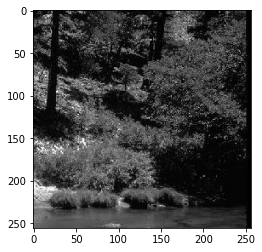

In [13]:
descript_train,stacked_descript_train,image_train=get_tiny_images(train_image_paths)
descript_test,stacked_descript_test,image_test=get_tiny_images(test_image_paths)

In [14]:
from sklearn.cluster import KMeans
# Perform k-means clustering and PCA
pca = PCA(n_components=128)
descriptors_test = pca.fit_transform(stacked_descript_test)
descriptors_train = pca.fit_transform(stacked_descript_train)
kmeans_test = KMeans(n_clusters = 10).fit(descriptors_test)
kmeans_train = KMeans(n_clusters = 10).fit(descriptors_train)
# voc_test, variance_test = kmeans(descriptors_test, numWords, 1) 
# voc_train, variance_train = kmeans(descriptors_train, numWords, 1) 


In [15]:
tot_train=len(train_labels)
tot_test=len(test_labels)

In [16]:
tot_train

1500

In [19]:

# Calculate the histogram of features Train
im_features_train = np.array([np.zeros(50) for i in range(tot_train)])
for i in range(tot_train):
  for j in range(len(descript_train[i])):
          feature = descript_train[i][j]
          feature = feature.reshape(1, 128)
          idx = kmeans_train.predict(feature)
          im_features_train[i][idx] += 1
im_features_train = preprocessing.normalize(im_features_train, norm='l2')
# Calculate the histogram of features Test
im_features_test = np.array([np.zeros(50) for i in range(tot_test)])
for i in range(tot_test):
  for j in range(len(descript_test[i])):
          feature = descript_test[i][j]
          feature = feature.reshape(1, 128)
          idx = kmeans_test.predict(feature)
          im_features_test[i][idx] += 1
im_features_test = preprocessing.normalize(im_features_test, norm='l2')    

In [20]:
from sklearn import preprocessing
from sklearn.svm import LinearSVC
from sklearn import preprocessing
import pdb

def svm_classify(train_image_feats, train_labels, test_image_feats):

    SVC = LinearSVC(C=700.0, class_weight=None, dual=True, fit_intercept=True,
                    intercept_scaling=1, loss='squared_hinge', max_iter= 2000,
                    multi_class='ovr', penalty='l2', random_state=0, tol= 1e-4,
                    verbose=0)
    SVC.fit(train_image_feats, train_labels)
    
    pred_label = SVC.predict(test_image_feats)

    return pred_label

In [23]:
result = svm_classify(im_features_train,train_labels, im_features_test)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [24]:
acc = float(len([x for x in zip(test_labels,result) if x[0]== x[1]]))/float(len(test_labels))
print("Accuracy = ", acc)

Accuracy =  0.07666666666666666


In [26]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(test_labels,result))
print(classification_report(test_labels,result))


[[ 98   1   0   0   0   0   0   0   0   0   0   0   0   0   1]
 [ 82  16   0   0   1   0   0   0   0   0   0   0   0   0   1]
 [ 91   1   0   0   0   0   0   0   0   0   0   0   0   0   8]
 [100   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 97   2   0   0   0   0   0   0   0   0   0   0   0   0   1]
 [ 99   0   0   0   0   0   0   0   0   0   0   0   0   0   1]
 [ 98   0   0   0   0   0   0   0   0   0   0   0   0   0   2]
 [100   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 96   1   0   0   0   0   1   0   0   0   0   0   0   0   2]
 [100   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 90   6   0   0   0   0   0   0   0   0   0   0   0   0   4]
 [ 98   1   0   0   0   0   0   0   0   0   0   0   0   0   1]
 [ 99   0   0   0   0   0   0   0   0   0   0   0   0   0   1]
 [100   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 91   8   0   0   0   0   0   0   0   0   0   0   0   0   1]]
              precision    recall  f1-score   support


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
